In [230]:
import sys
sys.path.append('src/features')

In [231]:
import pandas as pd
import numpy as np

from datetime import timedelta
from datetime import datetime

import re

import matplotlib.pyplot as plt
import seaborn as sns

In [232]:
import customplots
from customplots import target_features_plot, grid_serach_dt, col_import_plot

from dates_processor import *

In [233]:
import warnings
warnings.filterwarnings('ignore')

In [234]:
# Train data
data=pd.read_csv('data/mimic_train.csv')
print(data.shape)
data.head()

(20885, 44)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [235]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('data/mimic_test_death.csv')
print(data_test.shape)
data_test.sort_values('icustay_id').head()

(5221, 39)


,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [236]:
# I see that there are some columns in training not in test, let's keep the same in both
print([col for col in data.columns if col not in data_test.columns])

['HOSPITAL_EXPIRE_FLAG', 'DOD', 'DISCHTIME', 'DEATHTIME', 'LOS']


In [237]:
data.drop(['DOD', 'DISCHTIME', 'DEATHTIME', 'LOS'], axis = 1, inplace=True)
print(data.shape)
print(data_test.shape)

(20885, 40)
(5221, 39)


## Data exploration and feature engineering

### Target variable

0.11228154177639454
0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64


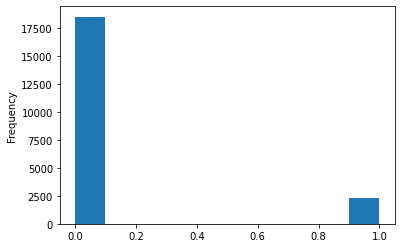

In [238]:
# Target variable
data['HOSPITAL_EXPIRE_FLAG'].plot(kind='hist')
print(data['HOSPITAL_EXPIRE_FLAG'].mean())
print(data['HOSPITAL_EXPIRE_FLAG'].value_counts())

In [239]:
# Join both train and test
data['from'] = 'train'
data_test['from'] = 'test'
df = pd.concat([data, data_test], axis = 0)
df.reset_index(inplace=True, drop=True)
print(df.shape)

(26106, 41)


### Dates and age

In [240]:
### Adjusting the format of the dates
df['DOB'] = pd.to_datetime(df['DOB'])
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])

<AxesSubplot:xlabel='Diff', ylabel='Density'>

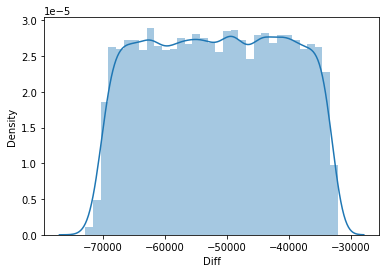

In [241]:
sns.distplot(df['Diff'])

1800
2181


<AxesSubplot:xlabel='DOB', ylabel='Density'>

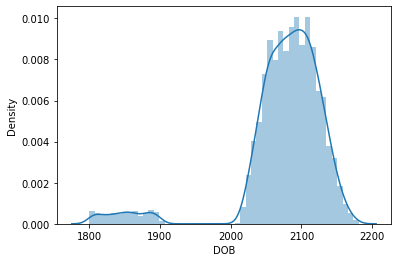

In [242]:
print(df['DOB'].dt.year.min())
print(df['DOB'].dt.year.max())
sns.distplot(df['DOB'].dt.year)

<AxesSubplot:ylabel='Density'>

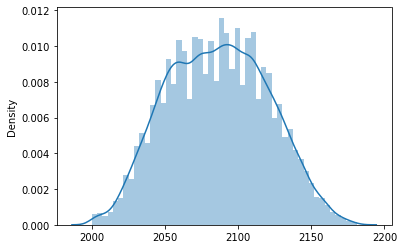

In [243]:
dob = np.where(df['DOB'].dt.year < 2000, df['DOB'].dt.year + 200, df['DOB'].dt.year)
sns.distplot(dob)

2100
2209


<AxesSubplot:xlabel='ADMITTIME', ylabel='Density'>

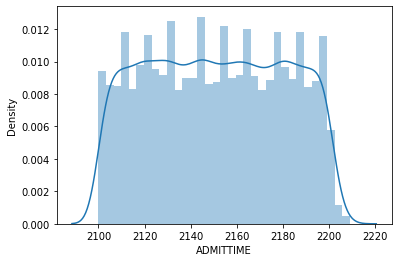

In [244]:
print(df['ADMITTIME'].dt.year.min())
print(df['ADMITTIME'].dt.year.max())
sns.distplot(df['ADMITTIME'].dt.year)

In [245]:
# Adjust days using diff
df['Diff_days'] = df['Diff'].apply(np.floor).apply(lambda x: pd.Timedelta(x, unit='D'))
df['DOB'] = np.where(df['DOB'].dt.year < 2000, df['DOB'] + df['Diff_days'] + pd.Timedelta(73000, unit='D'), df['DOB'] + df['Diff_days'])

df['ADMITTIME'] = df['ADMITTIME'] + df['Diff_days']
print(df['ADMITTIME'].dt.year.value_counts())
print(df['DOB'].dt.year.value_counts())

2008    6548
2009    5211
2010    5180
2011    5158
2012    4000
2007       9
Name: ADMITTIME, dtype: int64
1944    660
1946    605
1945    605
1947    597
1943    594
       ... 
1993     14
1901      8
1994      8
1995      4
1996      1
Name: DOB, Length: 90, dtype: int64


In [246]:
# Adjust the hours
df['Diff_h'] = ((np.abs(df['Diff']) % 1) * -24).round() # Number of hours to rest from the date according to the decimal points of Diff
df['Diff_h'] = df['Diff_h'].apply(lambda x: pd.Timedelta(x, unit='h'))
print(df['ADMITTIME'])
df['ADMITTIME'] = df['ADMITTIME'] + df['Diff_h']
print(df['ADMITTIME'])

0       2008-06-15 10:35:00
1       2010-12-26 22:34:00
2       2010-11-10 23:04:00
3       2011-09-26 08:00:00
4       2008-09-12 02:02:00
                ...        
26101   2008-05-31 11:01:00
26102   2008-04-03 10:45:00
26103   2009-12-17 04:04:00
26104   2011-11-22 07:15:00
26105   2011-08-20 07:15:00
Name: ADMITTIME, Length: 26106, dtype: datetime64[ns]
0       2008-06-14 15:35:00
1       2010-12-26 18:34:00
2       2010-11-10 00:04:00
3       2011-09-25 23:00:00
4       2008-09-11 08:02:00
                ...        
26101   2008-05-30 20:01:00
26102   2008-04-03 08:45:00
26103   2009-12-16 06:04:00
26104   2011-11-22 04:15:00
26105   2011-08-19 16:15:00
Name: ADMITTIME, Length: 26106, dtype: datetime64[ns]


<AxesSubplot:xlabel='AGE', ylabel='Density'>

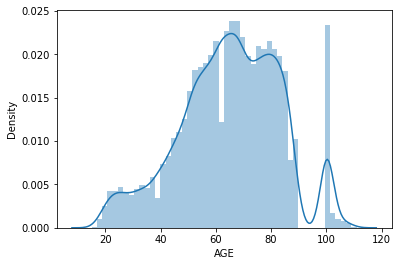

In [247]:
df['AGE'] = df['ADMITTIME'].dt.year - df['DOB'].dt.year
sns.distplot(df['AGE'])

In [248]:
# Age groups can be also a good idea
df['AGE_GROUP'] = (pd.cut(df['AGE'], [i for i in range(0, df['AGE'].max(), 5)])).astype(str)
df['AGE_GROUP'] = df['AGE_GROUP'].replace('nan', '(105.0, 110.0]')
print(df['AGE_GROUP'].isnull().sum())
df['AGE_GROUP'].value_counts()

0


(60.0, 65.0]      2925
(65.0, 70.0]      2910
(75.0, 80.0]      2644
(80.0, 85.0]      2527
(70.0, 75.0]      2457
(55.0, 60.0]      2442
(50.0, 55.0]      2259
(45.0, 50.0]      1552
(85.0, 90.0]      1310
(40.0, 45.0]      1108
(95.0, 100.0]      933
(35.0, 40.0]       759
(30.0, 35.0]       600
(20.0, 25.0]       537
(25.0, 30.0]       515
(100.0, 105.0]     373
(15.0, 20.0]       182
(105.0, 110.0]      71
(10.0, 15.0]         2
Name: AGE_GROUP, dtype: int64

In [249]:
# Using my processor for the creation of year, month, day , weekday and hour from a date column
dates_p = DatesPreprocessor()
df_d = dates_p.preprocess(df, ['ADMITTIME'])

In [250]:
# Delete columns I don't need
df_d = df_d.drop(['Diff', 'Diff_days', 'Diff_h'], axis=1)
df_d.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'from', 'AGE', 'AGE_GROUP',
       'ADMITTIME_year', 'ADMITTIME_month', 'ADMITTIME_day',
       'ADMITTIME_weekday', 'ADMITTIME_hour'],
      dtype='object')

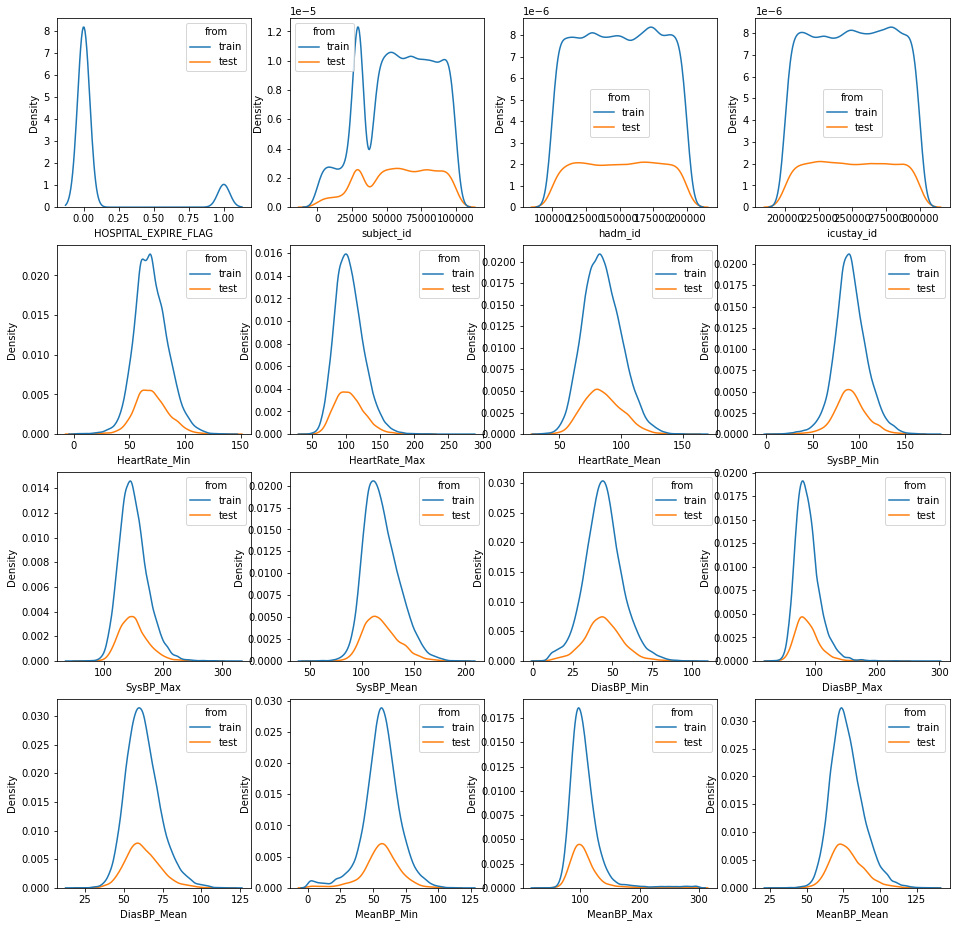

In [251]:
# Plot distribution of numeric features for train and test
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[:16], 'density')

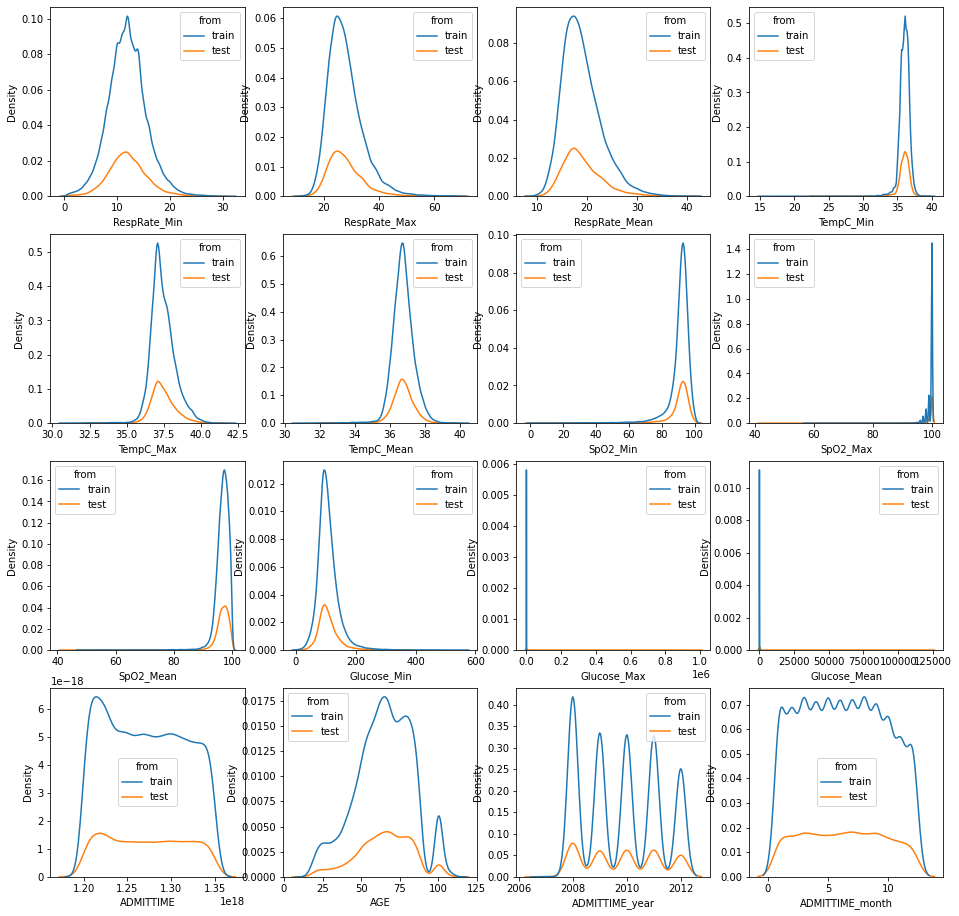

In [252]:
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[16:32], 'density')

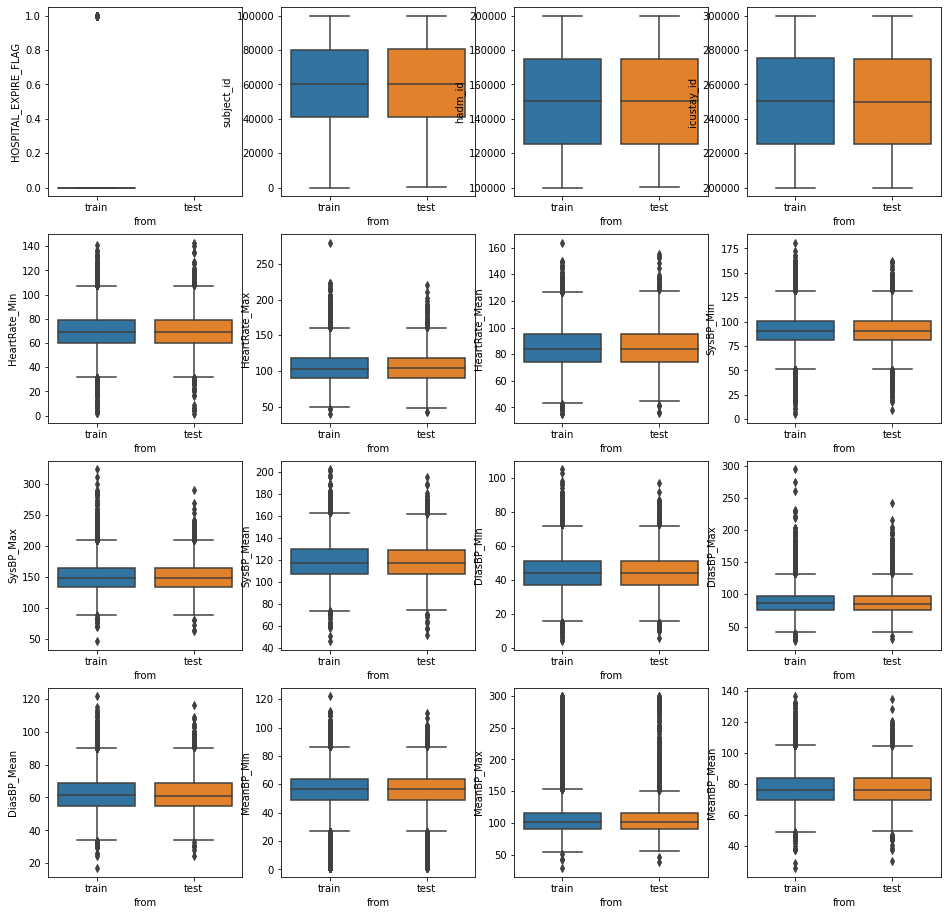

In [253]:
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[:16], 'boxplot')

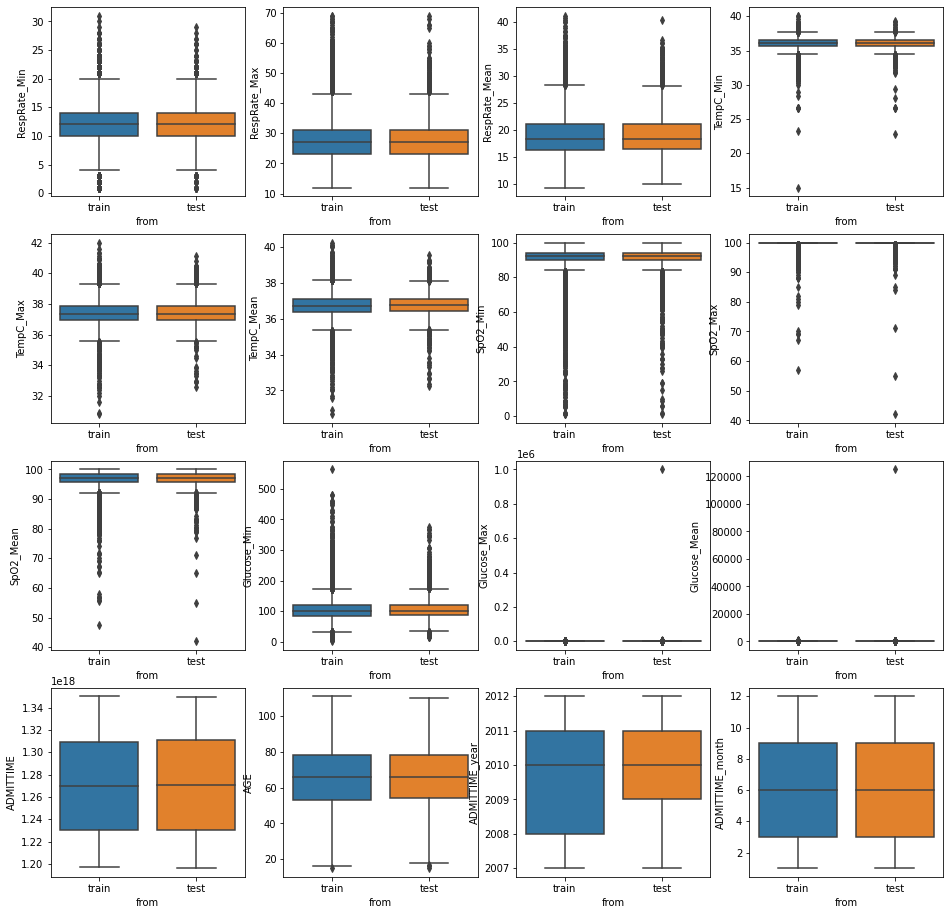

In [254]:
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[16:32], 'boxplot')

The distribution of the features is similar in both test and train data

### ICD9_diagnosis

Lets add the data with more diagnoses of the patients

In [229]:
df_more_diagnosis = pd.read_csv('data/extra_data/MIMIC_diagnoses.csv')
print(df_more_diagnosis.shape)
df_more_diagnosis.head()

(651047, 4)


,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [283]:
res_other_data = df_more_diagnosis.groupby('SUBJECT_ID').agg({"HADM_ID": "nunique",
                                                              "ICD9_CODE": "nunique"})
res_other_data.columns = ['n_stays', 'n_diagnoses']
res_other_data.head()

,n_stays,n_diagnoses
SUBJECT_ID,,
2,1,3
3,1,9
4,1,9
5,1,3
6,1,8


<AxesSubplot:xlabel='n_stays', ylabel='Density'>

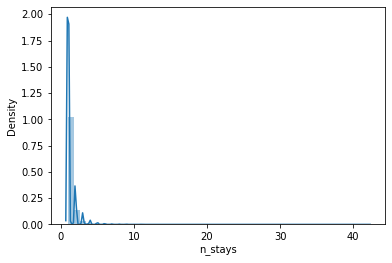

In [284]:
sns.distplot(res_other_data['n_stays'])

0    9
dtype: int64
12.615477214101462


<AxesSubplot:xlabel='n_diagnoses', ylabel='Density'>

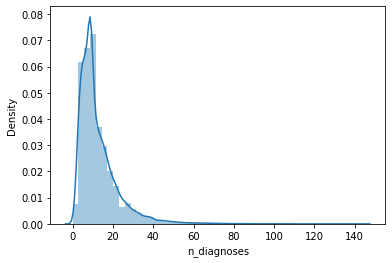

In [286]:
print(res_other_data['n_diagnoses'].mode())
print(res_other_data['n_diagnoses'].mean())
sns.distplot(res_other_data['n_diagnoses'])

In [325]:
# Since the mode for the number of other is 9, lets include them in the main data frame
filter_d = df_more_diagnosis['SEQ_NUM'] < 10
unique_id_icd =  df_more_diagnosis[['SUBJECT_ID', 'ICD9_CODE']].drop_duplicates()
unique_id_icd['seq'] = unique_id_icd.groupby('SUBJECT_ID').cumcount()

other_icd9 = unique_id_icd[unique_id_icd['seq'] < 10].pivot(index='SUBJECT_ID', columns = 'seq', values='ICD9_CODE')
other_icd9.columns = ['ICD9_CODE_O_'+str(i) for i in range(1,11)] 
other_icd9.reset_index(inplace=True)
other_icd9.fillna('99999', inplace=True)
other_icd9.head()

,SUBJECT_ID,ICD9_CODE_O_1,ICD9_CODE_O_2,ICD9_CODE_O_3,ICD9_CODE_O_4,ICD9_CODE_O_5,ICD9_CODE_O_6,ICD9_CODE_O_7,ICD9_CODE_O_8,ICD9_CODE_O_9,ICD9_CODE_O_10
0,2,V3001,V053,V290,99999,99999,99999,99999,99999,99999,99999
1,3,0389,78559,5849,4275,41071,4280,6826,4254,2639,99999
2,4,042,1363,7994,2763,7907,5715,04111,V090,E9317,99999
3,5,V3000,V053,V290,99999,99999,99999,99999,99999,99999,99999
4,6,40391,4440,9972,2766,2767,2859,2753,V1582,99999,99999


In [370]:
# Include the new vars in the main data frame
df_g = df_d.copy()
print(df_g.shape)
df_g = pd.merge(df_g, res_other_data, left_on= 'subject_id', right_on = 'SUBJECT_ID')
print(df_g.shape)
df_g = pd.merge(df_g, other_icd9, left_on= 'subject_id', right_on = 'SUBJECT_ID')
df_g.drop('SUBJECT_ID', axis=1, inplace=True)
print(df_g.shape)

(26106, 47)
(26106, 49)
(26106, 59)


In [371]:
df_g.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,ICD9_CODE_O_1,ICD9_CODE_O_2,ICD9_CODE_O_3,ICD9_CODE_O_4,ICD9_CODE_O_5,ICD9_CODE_O_6,ICD9_CODE_O_7,ICD9_CODE_O_8,ICD9_CODE_O_9,ICD9_CODE_O_10
0,0.0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,5789,51881,41071,42831,42732,2851,53550,79092,4280,42731
1,0.0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,53013,9351,E915,99999,99999,99999,99999,99999,99999,99999
2,0.0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,56983,56729,5845,5789,5121,5119,56889,E8788,3310,29410
3,0.0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,5533,48242,5163,4280,53081,73300,2720,4019,2440,30000
4,0.0,40708,194358,292786,80.0,114.0,96.274194,71.0,139.0,102.108108,...,5533,48242,5163,4280,53081,73300,2720,4019,2440,30000


Seeing the List of ICD-9 codes I realize that many ICD9 are wrong https://en.wikipedia.org/wiki/List_of_ICD-9_codes

It's a 3 digits of letter + 3 digits code

In [372]:
def fix_ICD9(text):
    text = re.sub(r'^0', r'', text) # replace those that start with ceros
    text = re.sub(r'(\d{3})(\d{2})', r'\1.\2', text) # include . when it has 5 digits
    text = re.sub(r'(\d{3})(\d{1})', r'\1.\2', text) # include . when it has 4 digits
    text = re.sub(r'(E)(\d+)', r'19\2', text) # replace E with 19
    text = re.sub(r'(V)(\d+)', r'29\2', text) # replace V with 29
    return text

In [373]:
df_g['ICD9_diagnosis_f1'] = np.round(df_g['ICD9_diagnosis'].apply(fix_ICD9).astype(float), 1)

In [374]:
df_g['ICD9_0_L1'] = pd.cut(x = df_g['ICD9_diagnosis_f1'], 
                         bins = [0, 139, 239, 279, 289, 319, 389, 459, 519, 579, 629, 679, 709, 739, 759, 779, 799, 999, df_g['ICD9_diagnosis_f1'].max()], 
                         labels=False)
df_g[['ICD9_0_L1', 'ICD9_diagnosis_f1']].head()

,ICD9_0_L1,ICD9_diagnosis_f1
0,8,578.9
1,8,530.1
2,8,569.8
3,8,553.3
4,6,410.7


<AxesSubplot:xlabel='ICD9_0_L1', ylabel='HOSPITAL_EXPIRE_FLAG'>

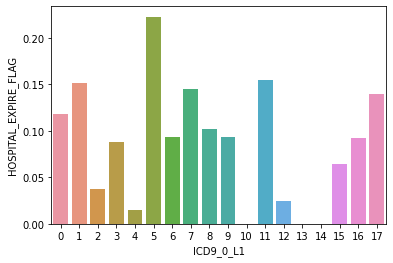

In [375]:
data_res = df_g.groupby('ICD9_0_L1').mean()['HOSPITAL_EXPIRE_FLAG'].to_frame().reset_index()
sns.barplot(x='ICD9_0_L1', y = 'HOSPITAL_EXPIRE_FLAG', data = data_res)

The ICD9 level 1 codes where the proportion of death is higher are 5: diseases of the nervous system and sense organs; 11: diseases of the skin and subcutaneous tissue; 17 : external causes of injury and 7:  diseases of the respiratory system.

On the other hand the, groups witht less proportion of deaths are 4: mental disorders; 10: complications of pregnancy, childbirth, and the puerperium; 13: congenital anomalies and 14: certain conditions originating in the perinatal period. 

The above 

<AxesSubplot:xlabel='ICD9_diagnosis_f1', ylabel='death_mean'>

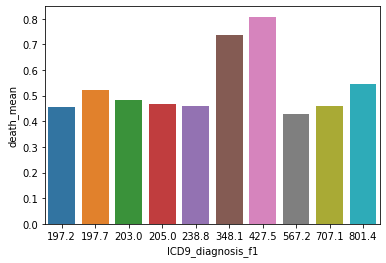

In [376]:
data_res_2 = df_g.groupby('ICD9_diagnosis_f1').agg({'HOSPITAL_EXPIRE_FLAG': ['mean', 'size']}).reset_index()
data_res_2.columns = ['ICD9_diagnosis_f1', 'death_mean', 'death_size']
data_res_2.sort_values(by='death_mean', ascending=False, inplace=True)

sns.barplot(x='ICD9_diagnosis_f1', y = 'death_mean', data = data_res_2[data_res_2['death_size']>10].head(10))

There are other diagnosis that have more correlation with the death of a patient. However, other 3-digit categories have only one or two patients with a proportion of death of 1.

Repeat the process for the other ICD COdes

In [377]:
for col in [col for col in df_g if col.startswith('ICD9_CODE_O')]:
    df_g[col+'_f1'] = np.round(df_g[col].apply(fix_ICD9).astype(float), 1)
    df_g[col+'_L1'] = pd.cut(x = df_g[col+'_f1'], 
                         bins = [0, 139, 239, 279, 289, 319, 389, 459, 519, 579, 629, 679, 709, 739, 759, 779, 799, 999, df_g[col+'_f1'].max()], 
                         labels=False)

df_g.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'from', 'AGE', 'AGE_GROUP',
       'ADMITTIME_year', 'ADMITTIME_month', 'ADMITTIME_day',
       'ADMITTIME_weekday', 'ADMITTIME_hour', 'n_stays', 'n_diagnoses',
       'ICD9_CODE_O_1', 'ICD9_CODE_O_2', 'ICD9_CODE_O_3', 'ICD9_CODE_O_4',
       'ICD9_CODE_O_5', 'ICD9_CODE_O_6', 'ICD9_CODE_O_7', 'ICD9_CODE_O_8',
       'ICD9_CODE_O_9', 'ICD9_CODE_O_10', 'ICD9_diagnosis_f1

### ID column  as index

In [378]:
#### ID column  as index
df_i = df_g.copy()
df_i.set_index(['icustay_id'], inplace=True)
df_i.drop(['subject_id', 'hadm_id'], axis=1, inplace=True)
df_i.head()

,HOSPITAL_EXPIRE_FLAG,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,ICD9_CODE_O_6_f1,ICD9_CODE_O_6_L1,ICD9_CODE_O_7_f1,ICD9_CODE_O_7_L1,ICD9_CODE_O_8_f1,ICD9_CODE_O_8_L1,ICD9_CODE_O_9_f1,ICD9_CODE_O_9_L1,ICD9_CODE_O_10_f1,ICD9_CODE_O_10_L1
icustay_id,,,,,,,,,,,,,,,,,,,,,
228357,0.0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,...,285.1,3,535.5,8,790.9,15,428.0,6,427.3,6
221004,0.0,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,...,1000.0,17,1000.0,17,1000.0,17,1000.0,17,1000.0,17
296315,0.0,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,...,511.9,7,568.9,8,19878.8,17,331.0,5,294.1,4
245557,0.0,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,...,733.0,12,272.0,2,401.9,6,244.0,2,300.0,4
292786,0.0,80.0,114.0,96.274194,71.0,139.0,102.108108,30.0,59.0,41.864865,...,733.0,12,272.0,2,401.9,6,244.0,2,300.0,4


### One-hot encoding and binary encoding

In [379]:
import category_encoders as ce

In [390]:
print(df_i.select_dtypes('object').columns)

Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 'FIRST_CAREUNIT', 'from',
       'AGE_GROUP', 'ICD9_CODE_O_1', 'ICD9_CODE_O_2', 'ICD9_CODE_O_3',
       'ICD9_CODE_O_4', 'ICD9_CODE_O_5', 'ICD9_CODE_O_6', 'ICD9_CODE_O_7',
       'ICD9_CODE_O_8', 'ICD9_CODE_O_9', 'ICD9_CODE_O_10'],
      dtype='object')


In [405]:
cat_vars_add = ['ICD9_diagnosis_f1', 'ICD9_0_L1',
       'ICD9_CODE_O_1_f1', 'ICD9_CODE_O_1_L1', 'ICD9_CODE_O_2_f1',
       'ICD9_CODE_O_2_L1', 'ICD9_CODE_O_3_f1', 'ICD9_CODE_O_3_L1',
       'ICD9_CODE_O_4_f1', 'ICD9_CODE_O_4_L1', 'ICD9_CODE_O_5_f1',
       'ICD9_CODE_O_5_L1', 'ICD9_CODE_O_6_f1', 'ICD9_CODE_O_6_L1',
       'ICD9_CODE_O_7_f1', 'ICD9_CODE_O_7_L1', 'ICD9_CODE_O_8_f1',
       'ICD9_CODE_O_8_L1', 'ICD9_CODE_O_9_f1', 'ICD9_CODE_O_9_L1',
       'ICD9_CODE_O_10_f1', 'ICD9_CODE_O_10_L1']

df_b = df_i.copy()
df_b[cat_vars_add] = df_b[cat_vars_add].astype(str)
print(df_b.select_dtypes('object').columns)
print(df_b.select_dtypes('object').nunique())

Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 'FIRST_CAREUNIT', 'from',
       'AGE_GROUP', 'ICD9_CODE_O_1', 'ICD9_CODE_O_2', 'ICD9_CODE_O_3',
       'ICD9_CODE_O_4', 'ICD9_CODE_O_5', 'ICD9_CODE_O_6', 'ICD9_CODE_O_7',
       'ICD9_CODE_O_8', 'ICD9_CODE_O_9', 'ICD9_CODE_O_10', 'ICD9_diagnosis_f1',
       'ICD9_0_L1', 'ICD9_CODE_O_1_f1', 'ICD9_CODE_O_1_L1', 'ICD9_CODE_O_2_f1',
       'ICD9_CODE_O_2_L1', 'ICD9_CODE_O_3_f1', 'ICD9_CODE_O_3_L1',
       'ICD9_CODE_O_4_f1', 'ICD9_CODE_O_4_L1', 'ICD9_CODE_O_5_f1',
       'ICD9_CODE_O_5_L1', 'ICD9_CODE_O_6_f1', 'ICD9_CODE_O_6_L1',
       'ICD9_CODE_O_7_f1', 'ICD9_CODE_O_7_L1', 'ICD9_CODE_O_8_f1',
       'ICD9_CODE_O_8_L1', 'ICD9_CODE_O_9_f1', 'ICD9_CODE_O_9_L1',
       'ICD9_CODE_O_10_f1', 'ICD9_CODE_O_10_L1'],
      dtype='object')
GENDER                  2
ADMISSION_TYPE          3
INSURANCE               5
RELIGION               17
MARITAL_STATUS          7
ET

In [406]:
# One hot encoding
print(len(df_b.columns))
to_o_encode = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'FIRST_CAREUNIT', 'AGE_GROUP']
df_b = pd.concat([df_b, pd.get_dummies(df_b[to_o_encode], drop_first = True)], axis=1)
print(len(df_b.columns))

78
107


In [407]:
# Binary encoding the cat features with many levels
print(len(df_b.columns))
to_bi_encode = ['RELIGION', 'ETHNICITY', 'DIAGNOSIS','ICD9_diagnosis', 'ICD9_0_L1', 'ICD9_CODE_O_1_L1',
              'ICD9_CODE_O_2_L1', 'ICD9_CODE_O_3_L1', 'ICD9_CODE_O_4_L1', 'ICD9_CODE_O_5_L1', 'ICD9_CODE_O_6_L1', 'ICD9_CODE_O_7_L1',
              'ICD9_CODE_O_8_L1', 'ICD9_CODE_O_9_L1', 'ICD9_CODE_O_10_L1', 'ICD9_CODE_O_1', 'ICD9_CODE_O_2', 'ICD9_CODE_O_3', 'ICD9_CODE_O_4',
       'ICD9_CODE_O_5', 'ICD9_CODE_O_6', 'ICD9_CODE_O_7', 'ICD9_CODE_O_8', 'ICD9_CODE_O_9', 'ICD9_CODE_O_10', 'ICD9_diagnosis_f1',
        'ICD9_CODE_O_1_f1', 'ICD9_CODE_O_2_f1','ICD9_CODE_O_3_f1', 'ICD9_CODE_O_4_f1', 'ICD9_CODE_O_5_f1', 'ICD9_CODE_O_6_f1',
        'ICD9_CODE_O_7_f1', 'ICD9_CODE_O_8_f1', 'ICD9_CODE_O_9_f1', 'ICD9_CODE_O_10_f1']
encoder = ce.BinaryEncoder(cols=to_bi_encode)
encoder = encoder.fit(df_b[to_bi_encode])

df_b = pd.concat([df_b, encoder.transform(df_b[to_bi_encode])], axis=1)
print(len(df_b.columns))

107
433


### Missing values

In [408]:
df_b.isnull().mean()

HOSPITAL_EXPIRE_FLAG    0.199992
HeartRate_Min           0.104650
HeartRate_Max           0.104650
HeartRate_Mean          0.104650
SysBP_Min               0.105685
                          ...   
ICD9_CODE_O_10_f1_6     0.000000
ICD9_CODE_O_10_f1_7     0.000000
ICD9_CODE_O_10_f1_8     0.000000
ICD9_CODE_O_10_f1_9     0.000000
ICD9_CODE_O_10_f1_10    0.000000
Length: 433, dtype: float64

In [409]:
# Create new columns that report if the row-column is missing or not
df_m = df_b.copy()
for col in df_m.columns[df_m.isnull().mean() > 0]:
    df_m[col+'_isna'] = (df_m[col].isna()).astype(int)

print(len(df_b.columns))
print(len(df_m.columns))

433
459


In [410]:
df_m.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean',
       ...
       'TempC_Min_isna', 'TempC_Max_isna', 'TempC_Mean_isna', 'SpO2_Min_isna',
       'SpO2_Max_isna', 'SpO2_Mean_isna', 'Glucose_Min_isna',
       'Glucose_Max_isna', 'Glucose_Mean_isna', 'MARITAL_STATUS_isna'],
      dtype='object', length=459)

In [411]:
# Delete the mising of the target var
df_m.drop(['HOSPITAL_EXPIRE_FLAG_isna'], axis=1, inplace=True)

#### Split data for imputation

In [412]:
y_train = df_m[df_m['from'] == 'train']['HOSPITAL_EXPIRE_FLAG']
X_train = df_m[df_m['from'] == 'train'].drop(['from', 'HOSPITAL_EXPIRE_FLAG'], axis=1)
X_test = df_m[df_m['from'] == 'test'].drop(['from', 'HOSPITAL_EXPIRE_FLAG'], axis=1)

print(y_train.shape, X_train.shape, X_test.shape)

(20885,) (20885, 456) (5221, 456)


In [413]:
print(X_train['MARITAL_STATUS'].isnull().sum())
print(X_test['MARITAL_STATUS'].isnull().sum())

722
180


In [414]:
# Fill marital estatus with the most common value by age group and gender
# Training data
X_train['MARITAL_STATUS'].fillna(X_train.groupby(['AGE_GROUP', 'GENDER'])['MARITAL_STATUS'].transform(lambda x: x.value_counts().idxmax()), inplace=True)

# Test data (with the values of the train data)
for index in X_test[X_test['MARITAL_STATUS_isna'] == 1].index:
    X_test['MARITAL_STATUS'][index] = X_train[(X_train['AGE_GROUP'] == X_test['AGE_GROUP'][index]) & (X_train['GENDER'] == X_test['GENDER'][index])]['MARITAL_STATUS'].value_counts().idxmax()

    
print(X_train['MARITAL_STATUS'].isnull().sum())
print(X_test['MARITAL_STATUS'].isnull().sum())

0
0


In [416]:
# Dummy of marital_status
X_train = pd.concat([X_train, pd.get_dummies(X_train['MARITAL_STATUS'], drop_first=True)], axis=1)
X_test = pd.concat([X_test, pd.get_dummies(X_test['MARITAL_STATUS'], drop_first=True)], axis=1)

In [417]:
X_train.select_dtypes('number').columns

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min',
       ...
       'Glucose_Min_isna', 'Glucose_Max_isna', 'Glucose_Mean_isna',
       'MARITAL_STATUS_isna', 'LIFE PARTNER', 'MARRIED', 'SEPARATED', 'SINGLE',
       'UNKNOWN (DEFAULT)', 'WIDOWED'],
      dtype='object', length=419)

In [419]:
any(X_train.select_dtypes('number').isnull().sum()>0)

True

In [420]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from datetime import datetime
from sklearn.neighbors import KNeighborsRegressor

num_cols = X_train.select_dtypes('number').columns

start_time = datetime.now()

my_imputer=IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=2), max_iter=30,add_indicator=True)
my_imputer.fit(X_train[num_cols])

X_train[num_cols] = my_imputer.transform(X_train[num_cols])
X_test[num_cols] = my_imputer.transform(X_train[num_cols])
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

print(any(X_train.isnull().sum()>0))
print(any(X_test.isnull().sum()>0))

ValueError: Must have equal len keys and value when setting with an ndarray